In [1]:
%matplotlib inline
from gym import spaces
import json
import datetime as dt
from matplotlib import pyplot as plt
import gym
from tqdm import tqdm 
COLAB = False
if not COLAB:
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras import Input
from utils import ReplayBuffer, OrnsteinUhlenbeckActionNoise
path_base = "./"
RESUME = False

In [2]:
MAX_Money = 10000
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self,df, train = True, number = 1, **kwargs):
        super(StockEnv,self).__init__()
        
        self.MAX_shares = 2147483647
        self.Min_Brokerage = 30
        self.Brokerage_rate = 0.001
        self.count  = number
        
        if "Balance" in kwargs.keys():
            Max_Money = kwargs["Balance"]
        if "Max_Shares" in kwargs.keys():
            self.MAX_shares = kwargs["Shares"]
        if "Broke_limit" in kwargs.keys():
            self.Min_Brokerage = kwargs["Broke_limit"]
        if "Broke_rate" in kwargs.keys():
            self.Brokerage_rate = kwargs["Broke_rate"]
        self.train = train
        self.dfs = df 
        assert len(df) == number, "Size of database not equal to number of stocks"
        self.max_step  = min([len(d.loc[:,'Open']) for d in self.dfs])
        self.action_space = spaces.Box(low = np.zeros(number), high = np.ones(number), dtype = np.float32)
        self.observation_space = spaces.Box(low=0,high=1, shape = (5,self.count), dtype=np.float32)
        
        
    def _get_price(self):
        return np.array([np.random.uniform(df.loc[self.current_step,"Open"], df.loc[self.current_step,"Close"]) for df in self.dfs])
    
    def _get_high(self):
        return np.array( [df.loc[self.current_step,"High"] for df in self.dfs])
 
    def _observe(self):
        frame = np.zeros((5,self.count))
        for i in range(self.count):
            frame[:,i] = np.array([self.dfs[i].loc[self.current_step,'Open'],self.dfs[i].loc[self.current_step,'High'],self.dfs[i].loc[self.current_step,'Low'],self.dfs[i].loc[self.current_step,'Close'],self.dfs[i].loc[self.current_step,'Volume'] ])
        frame = frame / self.highest_price
        frame[4,:] = frame[4,:]*self.highest_price / self.MAX_shares
        info = {
            'balance' : self.balance,
            'highest_price': self.highest_price,
            'current_price': self.current_price,
            #'time': self.df.loc[self.current_step,'time_stamp'],
            'shares_held': self.shares_held,
            'max_worth': self.max_net_worth,
            'broke_limit': self.Min_Brokerage,
            'broke_rate': self.Brokerage_rate,
            'max_shares': self.MAX_shares
        }
        return frame, info
    
    def reset(self, balance = MAX_Money, initial_shares = None, **kwargs):
        if initial_shares is None:
            initial_shares = np.zeros(self.count)
        if "Balance" in kwargs.keys():
            Max_Money = kwargs["Balance"]
        if "Max_Shares" in kwargs.keys():
            self.MAX_shares = kwargs["Shares"]
        if "Broke_limit" in kwargs.keys():
            self.Min_Brokerage = kwargs["Broke_limit"]
        if "Broke_rate" in kwargs.keys():
            self.Brokerage_rate = kwargs["Broke_rate"]
        
        if self.train:
            self.current_step = np.random.randint(0,len(self.dfs[0].loc[:,'Open'].values)-1)
        else:
            self.current_step = 0
        #print(self.current_step)
        self.balance = balance
        self.shares_held = np.zeros(self.count)
        self.current_price = self._get_price()
        self.net_worth = self.balance + np.sum(initial_shares*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        MAX_Money = self.net_worth
        self.highest_price = self._get_high()
        return  self._observe()
        
    def _broke(self,amount):
        return max(amount * self.Brokerage_rate,self.Min_Brokerage)
    
    def _take_action(self,act):
        self.current_price = self._get_price()
        high = self._get_high()
        for i in range(self.count):
            self.highest_price[i] = max(self.highest_price[i],high[i])
        act = act*self.MAX_shares
        b = 0
        for i in range(self.count):
            action = act[i]
            if action < 0:
                # sell
                action = -1*action
                if action > self.shares_held[i]:
                    action = self.shares_held[i]
                amount_gained = action*self.current_price[i]
                broke = self._broke(amount_gained)
                amount_gained -= broke
                if b+self.balance + amount_gained < 0:
                    a1 = np.floor((self.balance+b)/((self.Brokerage_rate-1)*self.current_price[i]))
                    action = np.floor(-(self.balance+b-self.Min_Brokerage)/self.current_price[i])
                    if self._broke(a1*self.current_price[i]) == a1*self.current_price[i]*self.Brokerage_rate:
                        action = max(a1,action)
                    action = max(action,0)
                    amount_gained = action*self.current_price[i]
                    amount_gained -= self._broke(amount_gained)
                b +=amount_gained
                self.shares_held[i] = self.shares_held[i]-action
                if self.shares_held[i] < 0:
                    frame, info = self._observe()
                    print(info)
                    assert 2 == 3, "shares going negative"
            elif action>0:
                #buy
                amount_required = self.current_price[i]*action + self._broke(self.current_price[i]*action)
                if amount_required > self.balance+b:
                    a1 = np.floor((self.balance+b)/((self.Brokerage_rate+1)*self.current_price[i]))
                    action = np.floor((self.balance+b-self.Min_Brokerage)/self.current_price[i])
                    if self._broke(a1*self.current_price[i]) == a1*self.current_price[i]*self.Brokerage_rate:
                        action = max(a1,action)
                    action = max(action,0)
                    amount_required = action*self.current_price[i]
                    amount_required -= self._broke(amount_required)
                b -= amount_required
                self.shares_held[i] += action
        self.balance+=b
        reward = self.balance + np.sum(self.shares_held * self.current_price) - self.net_worth
        self.net_worth = self.balance + np.sum(self.shares_held * self.current_price)
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth
        #MAX_Money = self.net_worth
        return reward
            
    def step(self,action):
#         print(actions)
#         print([actions[i] for i in range(self.count)])
#         print(np.array([actions[i] for i in range(self.count)]))
        if np.sum(action) > 1:
            action = action/np.sum(action)
        reward = self._take_action(action)
        self.current_step+=1
        if self.current_step > self.max_step-1:
            self.current_step = 0
        
        done = self.net_worth<=0
        obs, info = self._observe()
        return obs, reward, done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print(f'Step: {self.current_step}')
        print(f'Net Worth:{self.net_worth}')
        print(f'Profit: {profit}')
        
def create_stock_env(locations, train=True):
    dfs = [pd.read_csv(location).sort_values('Date') for location in locations]
#     for df in dfs:
#         print(len(df.loc[:,'Open']))
#     for df in dfs:
#         print(df.shape)
    return StockEnv(dfs, train, len(locations))

In [3]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.hidden_layers = params["actor_hidden_layers"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.actor = self.model()
        
    def model(self):
        inputs = Input(shape=(1,self.state_dimensions))
        x = Lambda(lambda x: x)(inputs)
        for layer in self.hidden_layers:
            x = Dense(layer, activation='relu')(x)
        x = Dense(self.action_dimensions, activation='tanh')(x)
        x = Lambda(lambda x: x*self.output_range)(x)
        model = tf.keras.Model(inputs = inputs, outputs = x)
        return model
    
    def get_action(self, state):
        state_tensor = tf.Variable(shape = state.shape, initial_value = state.astype('float32'))
        #print('before')
        #print(state_tensor)
        act = (self.actor(state_tensor)).numpy()
        #print('after')
        #print(act)
        return act
    
    def save_weights(self):
        self.actor.save_weights(path_base + "actor.h5")
               
    def load_weights(self):
        self.actor.load_weights(path_base + "actor.h5")
        print("Load")
        
    
class Critic:
    def __init__(self, params):
        self.hidden_layers = params["critic_hidden_layers"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.optimizer = params["critic_optimizer"]
        self.critic_online = self.model()
        self.critic_target = self.model()


    def model(self):
        input_a = Input(shape = (1, self.state_dimensions))
        input_b = Input(shape = (1, self.action_dimensions))
        x = concatenate([input_a, input_b], axis=-1)
        for layer in self.hidden_layers:
            x = Dense(layer, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = tf.keras.Model(inputs=[input_a, input_b], outputs = x)
        model.compile(loss='mse', optimizer=self.optimizer)
        return model
    
    def save_weights(self):
        self.critic_online.save_weights(path_base + "critic_online.h5")
        self.critic_target.save_weights(path_base +  "critic_target.h5")
               
    def load_weights(self):
        self.critic_online.load_weights(path_base + "critic_online.h5")
        self.critic_target.load_weights(path_base + "critic_target.h5")

    def get_qvalues(self, state_array, action_array, online=True):
        state_tensor = tf.Variable(shape = state_array.shape, initial_value = state_array.astype('float32'))
        action_tensor = tf.Variable(shape = action_array.shape, initial_value = action_array.astype('float32'))
        return (self.critic_online([state_tensor, action_tensor]).numpy() if online else self.critic_target([state_tensor, action_tensor]).numpy())
    
    def call(self, state_tensor, action_tensor, online = True):
#         print('before')
#         print(state_tensor)
#         print(action_tensor)
        return (self.critic_online([state_tensor, action_tensor]) if online else self.critic_target([state_tensor, action_tensor]))
    
    def merge_networks(self, tau):
        self.critic_target.set_weights(tau*np.array(self.critic_online.get_weights())
                                                                    + (1-tau)*np.array(self.critic_target.get_weights()))
        

In [4]:
class Agent:
    def __init__(self, params, test=False):
        self.test = test
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayBuffer(params["buffer_size"])
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.action_range = params["output_range"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.tau = params["tau"]
        self.step = 0
        self.noise_func =  OrnsteinUhlenbeckActionNoise(mu=np.zeros(params["action_dimensions"]))
        if RESUME:
            self.load_networks()
        
        
    def agent_start(self, observation):
        observation = np.reshape(observation, (1, self.state_dimensions))
        act = np.squeeze(self.actor.get_action(observation))
        if not self.test:
            for i in range(act.shape[0]):
                act[i] = np.squeeze(self.clip_action((act[i] + self.noise_func())[0]))
        else:
            for i in range(act.shape[0]):
                act[i] = np.squeeze(self.clip_action(act[i]))
        self.prev_state = observation
        self.prev_action = act
        return act

    def clip_action(self, action):
        if np.abs(action) > self.action_range:
            action *= abs(self.action_range)/abs(action)
        
        return action

    def agent_step(self, reward, observation):
        observation = np.reshape(observation, (1, self.state_dimensions))
        if not self.test:
            relay = (self.prev_state, self.prev_action, reward, observation)
            self.buffer.add(relay)
        self.prev_state = observation
        act = np.squeeze(self.actor.get_action(observation))
        if not self.test:
             for i in range(act.shape[0]):
                self.prev_action[i] = np.squeeze(self.clip_action((act[i] + self.noise_func())[0]))
           # self.prev_action = self.clip_action(act + self.noise_func())
             self.train(self.batch_size)
        else:
            for i in range(act.shape[0]):
                self.prev_action[i] = np.squeeze(self.clip_action((act[i] + self.noise_func())[0]))
            
        return self.prev_action 
    
    def save_networks(self):
        self.actor.save_weights()
        self.critic.save_weights()

    def load_networks(self):
        self.actor.load_weights()
        self.critic.load_weights()


    def train(self, sample_size):
        self.step += 1
        batch, batch_size = self.buffer.sample(sample_size)
        #print(batch)
        state_array = np.array([ element[3] for element in batch])
        #print(state_array.shape)
        #state_array = np.reshape(state_array, (1, self.state_dimensions))
        action_array = self.actor.get_action(state_array)
        prev_state_array = np.array([ element[0] for element in batch])
        prev_action_array = np.array([ [element[1]] for element in batch])
        #print(prev_action_array)
        
#         state_array = np.reshape(state_array, (1,1, self.state_dimensions)) 
#         action_array = np.reshape(action_array, (1,1, self.action_dimensions)) 
#         prev_state_array = np.reshape(prev_state_array, (1,1, self.state_dimensions)) 
#         prev_action_array = np.reshape(prev_action_array, (1,1, self.action_dimensions)) 
        
        output = self.critic.get_qvalues(state_array, action_array, False)
        output = np.array([element[2] + self.discount*out[0] for element, out in zip(batch, output)])
        
        self.critic.critic_online.fit([state_array, action_array], output, verbose=0)

        prev_state_tensor = tf.Variable(shape = prev_state_array.shape, initial_value = prev_state_array.astype('float32'))
        prev_action_tensor = tf.Variable(shape = prev_action_array.shape, initial_value = prev_action_array.astype('float32'))
        
        with tf.GradientTape(persistent=True) as g:
            g.watch(prev_action_tensor) 
            g.watch(prev_state_tensor)
            value = self.critic.call(prev_state_tensor, prev_action_tensor)
            action = self.actor.actor(prev_state_tensor)
            
        gradient = -tf.squeeze(g.gradient(value, prev_action_tensor))
        gradient = tf.cast(gradient, tf.float32)
        gradient_actor = g.gradient(action, self.actor.actor.trainable_weights, gradient)
        gradient_actor = list(map(lambda x: tf.math.divide(x, batch_size), gradient_actor))
        self.optimizer.apply_gradients(zip(gradient_actor, self.actor.actor.trainable_weights))
        self.critic.merge_networks(self.tau)

        if self.step%self.save_frequency == 0:
            self.save_networks()



In [5]:
AGENT_PARAMS = {
	"output_range": 1,
	"actor_hidden_layers": [60, 16],
	"critic_hidden_layers": [60, 16],
	"state_dimensions": 10,
	"action_dimensions": 2,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.001),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0001),
	"batch_size": 64,
	"buffer_size":1000000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 100
}

In [6]:
files = ['AAPL.csv','MSFT.csv']
env = create_stock_env(files)

/home/geekpradd/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
env = create_stock_env(files,0)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS)
ITERATIONS = 5000
profit = np.zeros((10,ITERATIONS))
action = np.zeros((10,ITERATIONS+1,AGENT_PARAMS["action_dimensions"]))
shares = np.zeros((10,ITERATIONS+1,AGENT_PARAMS["action_dimensions"]))
for iter in range(10):
    prev_profit = 0
    y, info = env.reset()
    y[0:-1,:] = y[0:-1,:]*info['highest_price']
    y[-1,:] = y[-1,:]*info['max_shares']
    action[iter,0,:] = agent.agent_start(y)
    for i in tqdm(range(ITERATIONS)):
        shares[iter,i,:] = info['shares_held']
        y, reward, done, info = env.step(action[iter,i])
        y[0:-1,:] = y[0:-1,:]*info['highest_price']
        y[-1,:] = y[-1,:]*info['max_shares']
        action[iter,i+1,:] = agent.agent_step(reward, y)
        profit[iter][i] += reward + prev_profit
        prev_profit += reward

  4%|▎         | 181/5000 [00:08<03:45, 21.36it/s]


{'balance': -19.092973340166736, 'highest_price': array([ 43.75, 120.98]), 'current_price': array([ 37.07762731, 107.99521303]), 'shares_held': array([-1.,  0.]), 'max_worth': 10579.254141816942, 'broke_limit': 30, 'broke_rate': 0.001, 'max_shares': 2147483647}


AssertionError: shares going negative

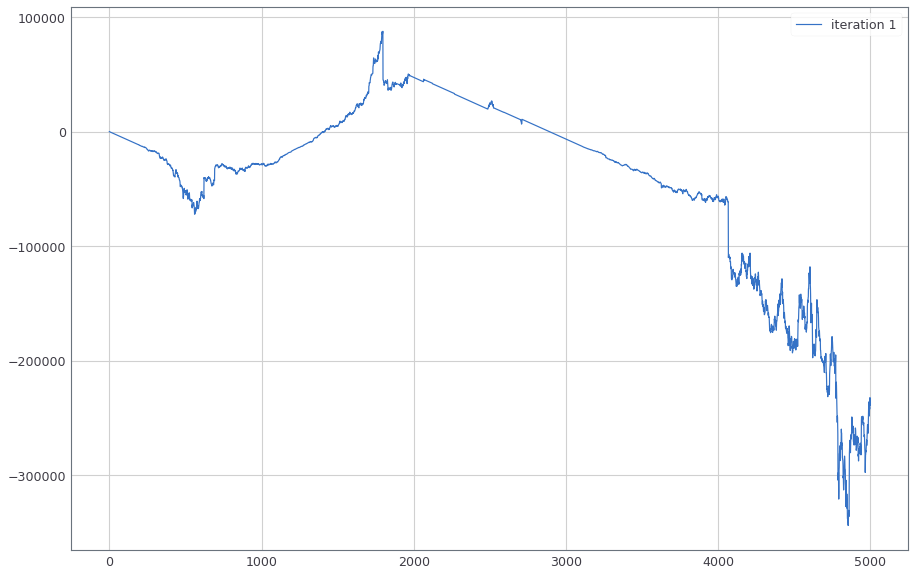

In [33]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
plt.plot(profit[1,:])
plt.legend(['iteration '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

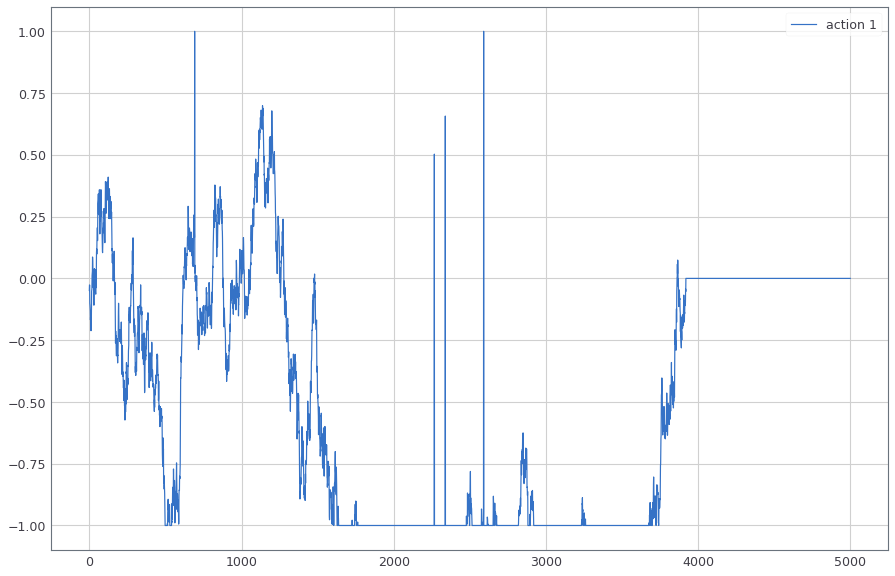

In [29]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
plt.plot(action[3,:,1])
plt.legend(['action '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

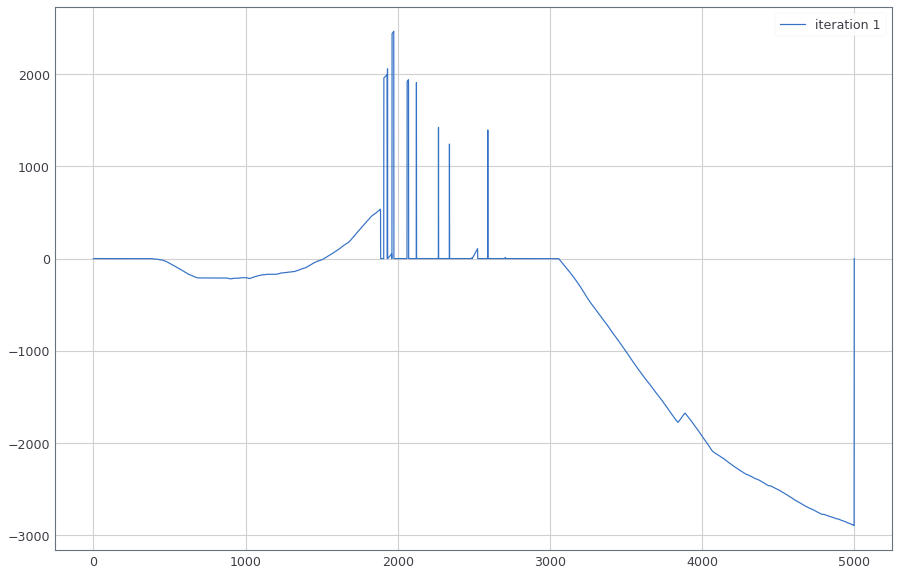

In [32]:
plt.figure(figsize = [15, 10])
plt.plot(shares[1,:,1])
plt.legend(['iteration '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

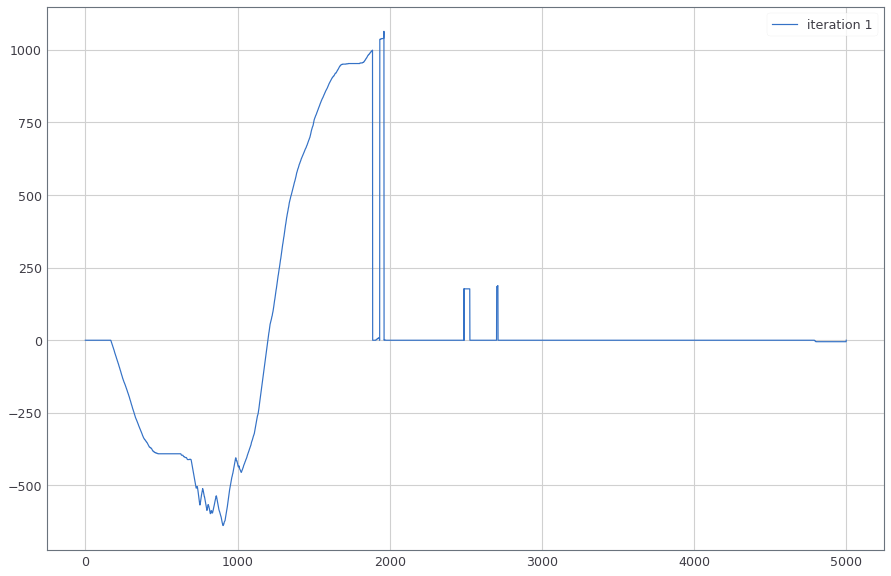

In [31]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
plt.plot(shares[1,:,0])
plt.legend(['iteration '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

 ...]

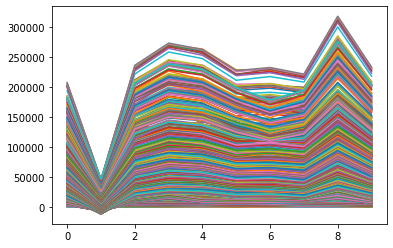

In [10]:
plt.plot(profit)

In [11]:
print(min(profit),max(profit),profit[-1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [98]:
env = create_stock_env(files,False)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS, True)
ITERATIONS = 5000
profit = np.zeros(ITERATIONS)
action = np.zeros((ITERATIONS+1,AGENT_PARAMS["action_dimensions"]))
shares = np.zeros((ITERATIONS+1,AGENT_PARAMS["action_dimensions"]))
balance = np.zeros(ITERATIONS+1)
prev_profit = 0
y, info = env.reset()
y[0:-1,:] = y[0:-1,:]*info['highest_price']
y[-1,:] = y[-1,:]*info['max_shares']
action[0,:] = agent.agent_start(y)
for i in tqdm(range(ITERATIONS)):
    shares[i,:] = info['shares_held']
    balance[i] =  info['balance']
    y, reward, done, info = env.step(action[i])
    y[0:-1,:] = y[0:-1,:]*info['highest_price']
    y[-1,:] = y[-1,:]*info['max_shares']
    action[i+1,:] = agent.agent_step(reward, y)
    profit[i] += reward + prev_profit
    prev_profit += reward

/home/harshit/anaconda3/envs/my_env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  0%|          | 0/20000 [00:00<?, ?it/s]

Load
0


100%|██████████| 20000/20000 [11:46<00:00, 28.30it/s]


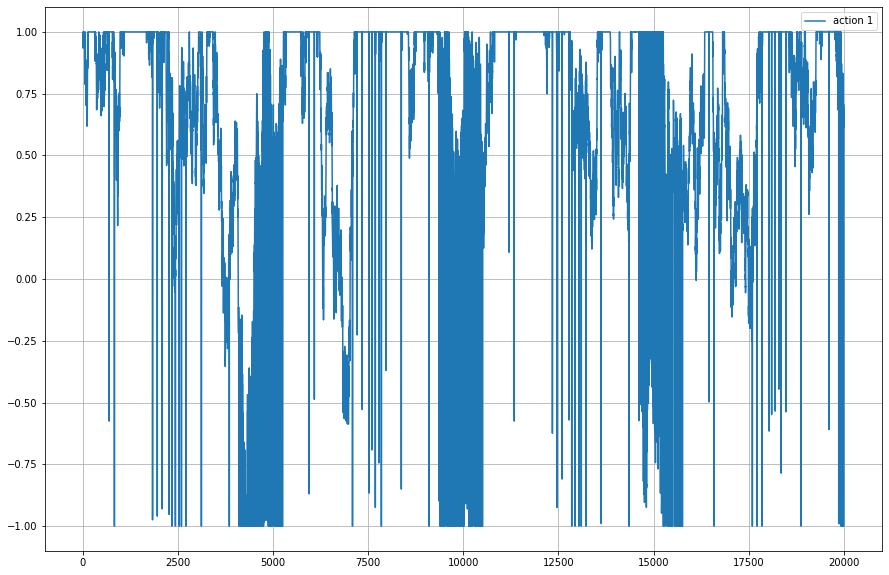

In [99]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
plt.plot(action[:,1])
plt.legend(['action '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

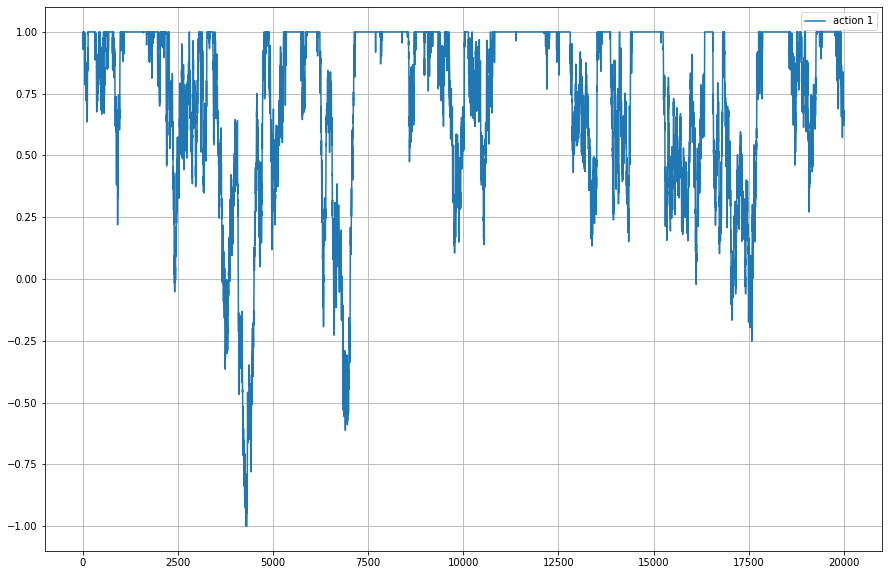

In [100]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
plt.plot(action[:,0])
plt.legend(['action '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

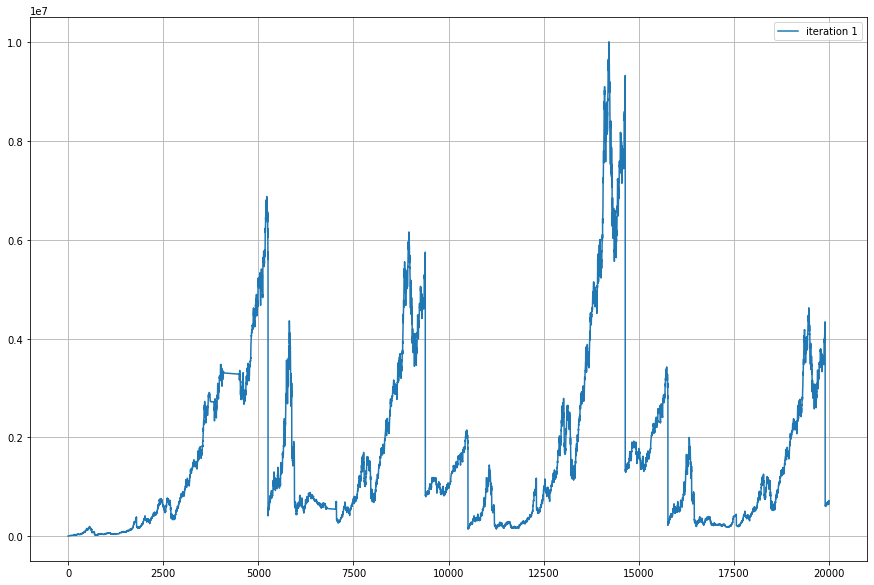

In [101]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
plt.plot(profit)
plt.legend(['iteration '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

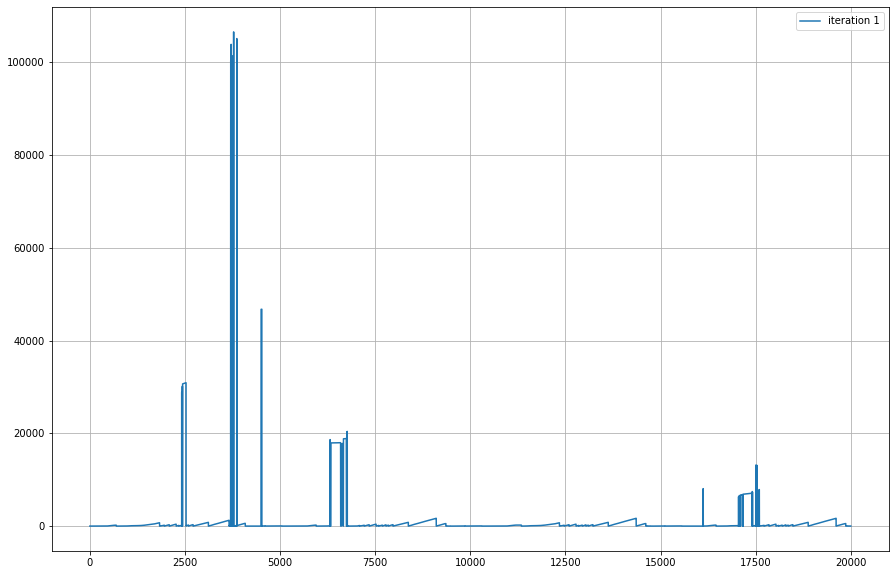

In [102]:
plt.figure(figsize = [15, 10])
plt.plot(shares[:,1])
plt.legend(['iteration '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

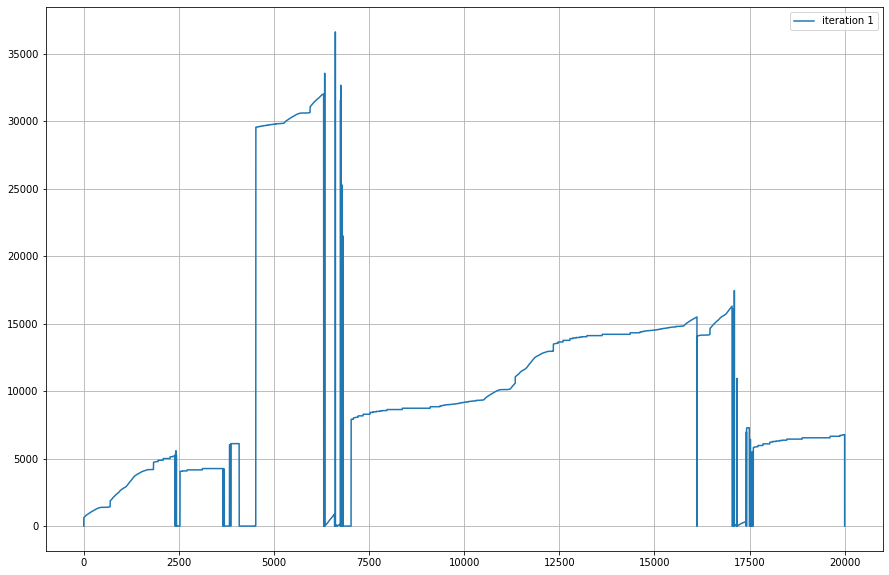

In [103]:
plt.figure(figsize = [15, 10])
plt.plot(shares[:,0])
plt.legend(['iteration '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

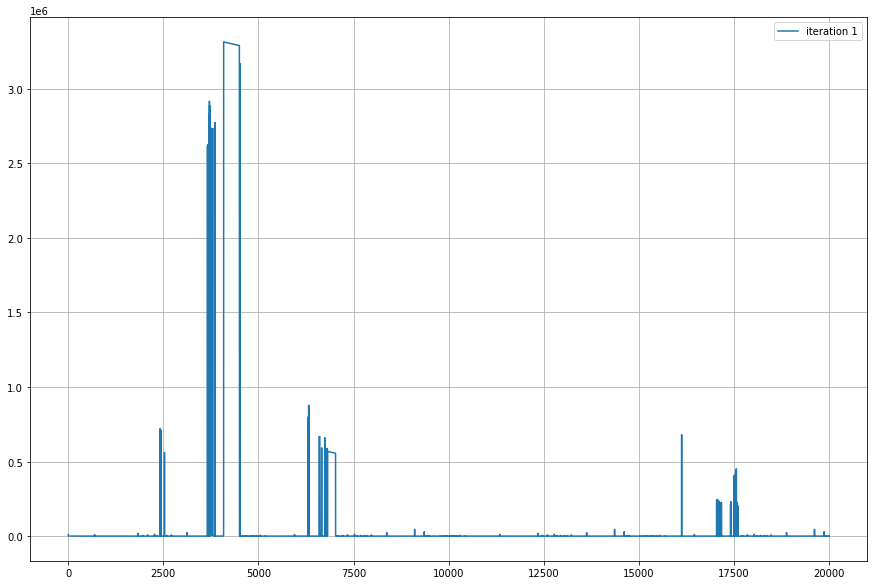

In [125]:
plt.figure(figsize = [15, 10])
plt.plot(balance)
plt.legend(['iteration '+str(i+1) for i in range(10)])
plt.grid(True)
plt.show()